In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 100
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 150,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    print("Pretrained model loaded")
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
else:
    print("Loaded empty model")
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer)
def test_regular_sampler():
    print(model_manager.say_raw("How are you? I'm", 50, 0.7))
test_regular_sampler()

How are you? I'm the new head of the school. You know how I like to write and do whatever I want. It's not that I'm not interested, it's just that I don't know what to write about."

"I know you're a lot of things," I said. "But it's the only thing that you can really say to me."

"I don't want to talk about it."

"You don't have to," I said. "It's not that I don't like you. I just don't know what to write about."

"I don


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [7]:
train_results = {}
model.train()
train_model(model, tokenizer, config, train_results)

Dataset demo snapshot:
<d><scn>facin2<msg>An "Just one of the perks of being the manager of this facility."<|endoftext|><d><scn>black<msg>n "Of course, that complicated things. My committee was once again tasked with judging the viability of the different projects, and while I intended to stay impartial on the matter, she would probably be seen as an influence due to our relationship."<|endoftext|><d><scn>emeraroom<msg>Em "Not really. You know how a brush works, don't you?"<|endoftext|><d><scn>o2<msg>Br
 "Alright."<|endoftext|><p><msg>c "Maybe we can collaborate."<d><scn>loremapt<msg>Ip "I certainly hope so."<|endoftext|><d><scn>black<msg>Br "Waiter... next round."<|endoftext|><p><msg>c "I was just asking a question, that's all."<|endoftext|><d><scn>park3<msg>Em "Good. Considering all the murders took place during the night, I'll certainly need it. Long days are endemic in my line of work."<|endoftext|><p><msg>c "They can be.
[0] set freeze_part_layers: True (freezing 150 out of 160 la

Step,Training Loss
105,3.267100
210,2.493300
315,2.327800
420,2.244100
525,2.207900
630,2.167500
735,2.154900
840,2.136100
945,2.122700
1050,2.104400


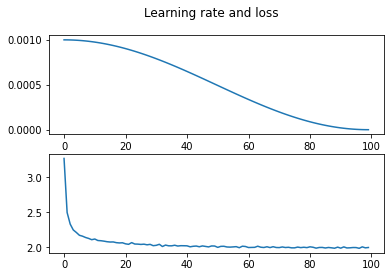

In [8]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [9]:
model.eval()
test_regular_sampler()

How are you? I'm just an outsider."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [ ]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

# Sampling test

This is gonna be interesting!

In [14]:
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "I'm fine."<d><scn>park2<msg>Ry "What do you think?"<p><msg>c "I think you're overqualified to be a doctor, and you're just trying to save the day."<d><scn>park2<msg>Ry "Yeah, but you're also doing something for me."<p><msg>

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "Well, you know he's not a doctor, but that's something I should get out of here."<p><msg>c "Well, I guess it's nice to have someone in the company of you."<d><scn>park2<msg>Ad "Oh, well, I'll just have to be careful about the

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: facin3<msg>An "Adine, you can sit on my bench. I can't."<p><msg>c "Oh my god, Adine. What is this?"<d><scn>facin3<msg>An "Adine, you can sit on my bench. I can't."<p><msg>c "Oh my god, Adine. What is this

[Test 1] -> Prompt: What will we do here?
Reply: neurofur<msg>n "We'll go to the woods and catch the birds first."<d><scn>neurofur<msg>n "I will."<p><msg>c "Wha

KeyboardInterrupt: 

In [12]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?


NameError: name 'generate_dragon_reply' is not defined